In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [47]:
data_dir = "/home/x245zhou/verify-c-common/data"
data_arm = pd.read_csv(f"{data_dir}/horn-bv2-lambdas_false_horn-hybrid-array_horn-based-ptr-obj_horn-hybrid-use-arm.brunch.csv")
data_base = pd.read_csv(f"{data_dir}/horn-bv2-lambdas_false_horn-hybrid-array_horn-based-ptr-obj.brunch.csv")
# other mem reprs
data_arrays = pd.read_csv(f"{data_dir}/horn-bv2-lambdas_false.brunch.csv")
data_lambdas = pd.read_csv(f"{data_dir}/base.brunch.csv")

In [22]:
data_arm = data_arm.fillna(value={'bmc_solve_time': 200, 'bmc_time': 200, "hybrid_row" : 1, "hybrid_thm_skip_store" : 0, "hybrid_arm_skip_store" : 0, "hybrid_arm_skip_memset" : 0, "hybrid_arm_skip_memcpy" : 0})
data_base = data_base.fillna(value={'bmc_solve_time': 200, 'bmc_time': 200, "hybrid_row" : 1, "hybrid_thm_skip_store" : 0, "hybrid_arm_skip_store" : 0, "hybrid_arm_skip_memset" : 0, "hybrid_arm_skip_memcpy" : 0})

In [48]:
data_arrays = data_arrays.fillna(value={'bmc_solve_time': 200, 'bmc_time': 200, "hybrid_row" : 1, "hybrid_thm_skip_store" : 0, "hybrid_arm_skip_store" : 0, "hybrid_arm_skip_memset" : 0, "hybrid_arm_skip_memcpy" : 0})
data_lambdas = data_lambdas.fillna(value={'bmc_solve_time': 200, 'bmc_time': 200, "hybrid_row" : 1, "hybrid_thm_skip_store" : 0, "hybrid_arm_skip_store" : 0, "hybrid_arm_skip_memset" : 0, "hybrid_arm_skip_memcpy" : 0})

In [24]:
data_arm['hybrid_row_removed'] = data_arm["hybrid_thm_skip_store"] + data_arm["hybrid_arm_skip_store"] + data_arm["hybrid_arm_skip_memset"] + data_arm["hybrid_arm_skip_memcpy"]

In [25]:
data_base['hybrid_row_removed'] = data_base["hybrid_thm_skip_store"]


In [26]:
data_base['hybrid_row_removed'].agg(["sum", "count", "mean"]).round(0)

sum      648.0
count    228.0
mean       3.0
Name: hybrid_row_removed, dtype: float64

In [27]:
data_arm['hybrid_row_removed'].agg(["sum", "count", "mean"]).round(0)

sum      9837.0
count     228.0
mean       43.0
Name: hybrid_row_removed, dtype: float64

In [66]:
# similar table as the one found in LPAR paper
data_base["bmc_pre_proc_time"] = data_base["bmc_time"] - data_base["bmc_solve_time"]
data_arm["bmc_pre_proc_time"] = data_arm["bmc_time"] - data_arm["bmc_solve_time"]

In [67]:
data_arrays["bmc_pre_proc_time"] = data_arrays["bmc_time"] - data_arrays["bmc_solve_time"]
data_lambdas["bmc_pre_proc_time"] = data_lambdas["bmc_time"] - data_lambdas["bmc_solve_time"]

In [29]:
data_base_sum_tab = data_base[["bmc_pre_proc_time", "bmc_solve_time", "hybrid_row", "hybrid_row_removed"]].agg(["sum"]).astype(int)
data_arm_sum_tab = data_arm[["bmc_pre_proc_time", "bmc_solve_time", "hybrid_row", "hybrid_row_removed"]].agg(["sum"]).astype(int)

In [30]:
data_base_sum_tab["config"] = "base"
data_arm_sum_tab["config"] = "arm"
sum_tab = pd.concat([data_base_sum_tab, data_arm_sum_tab])
sum_tab

,bmc_pre_proc_time,bmc_solve_time,hybrid_row,hybrid_row_removed,config
sum,8,883,84279,648,base
sum,7,697,83460,9837,arm


In [31]:
arm_base_joined = pd.merge(data_arm, data_base, how="left", on="job_name", suffixes=("_arm", "_base"))

### Fine-grained comparison

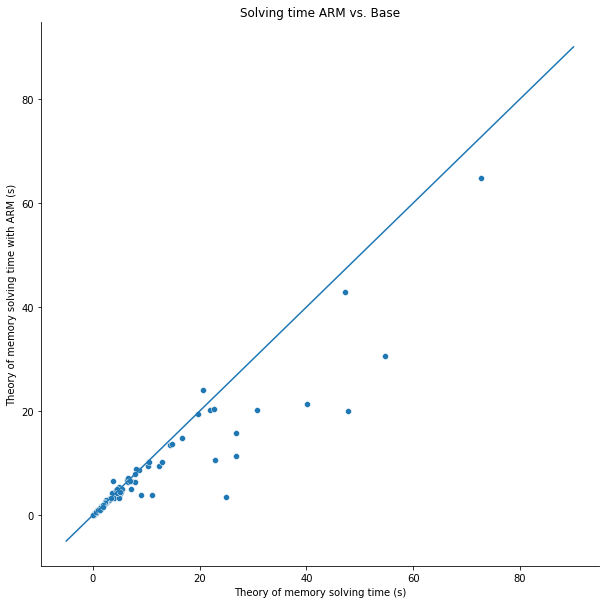

In [39]:
fig = plt.figure(figsize=(10,10))
plt.title('Solving time ARM vs. Base')
# Set x-axis label
plt.xlabel('Theory of memory solving time (s)')
# Set y-axis label
plt.ylabel('Theory of memory solving time with ARM (s)')
g = sns.scatterplot(x="bmc_solve_time_base", y="bmc_solve_time_arm", data=arm_base_joined)
sns.despine()
x = np.linspace(-5, 90, 2)
plot = g.plot(x, x)

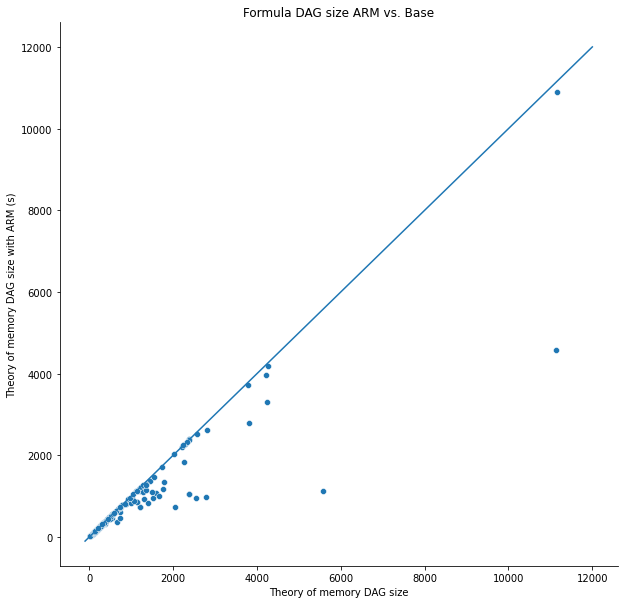

In [33]:
fig = plt.figure(figsize=(10,10))
plt.title('Formula DAG size ARM vs. Base')
# Set x-axis label
plt.xlabel('Theory of memory DAG size')
# Set y-axis label
plt.ylabel('Theory of memory DAG size with ARM (s)')
g = sns.scatterplot(x="bmc_dag_size_base", y="bmc_dag_size_arm", data=arm_base_joined)
sns.despine()
x = np.linspace(-100, 12000, 2)
plot = g.plot(x, x)

## Solving time reduction in relation to R-O-W removal

In [146]:
arm_base_joined["row_reduction_perc"] = arm_base_joined["hybrid_row_removed_arm"] / arm_base_joined["bmc_dag_size_arm"]


In [147]:
arm_base_joined["bmc_solve_time_perc"] = (arm_base_joined["bmc_solve_time_base"] - arm_base_joined["bmc_solve_time_arm"]) / arm_base_joined["bmc_solve_time_base"]

In [151]:
cleaned = arm_base_joined[(arm_base_joined["bmc_solve_time_base"].astype(float) > 2.5) & (arm_base_joined["hybrid_row_removed_arm"] > 0)]

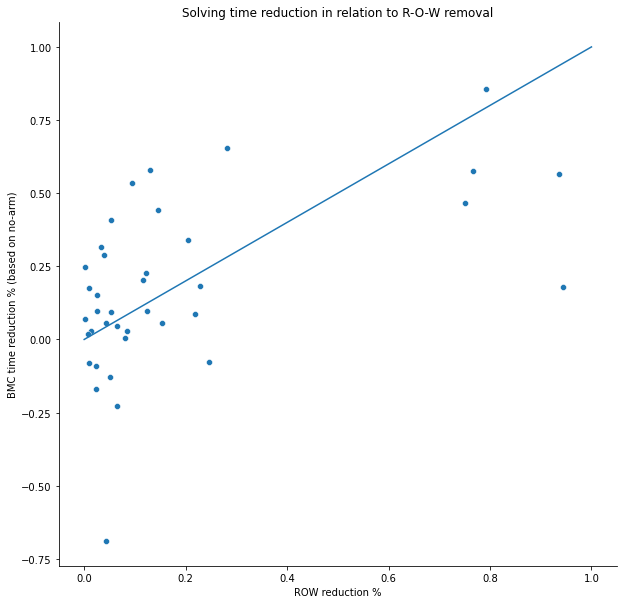

In [152]:
fig = plt.figure(figsize=(10,10))
plt.title('Solving time reduction in relation to R-O-W removal')
# Set x-axis label
plt.xlabel('ROW reduction %')
# Set y-axis label
plt.ylabel('BMC time reduction % (based on no-arm)')
g = sns.scatterplot(x="row_reduction_perc", y="bmc_solve_time_perc", data=cleaned)
sns.despine()
x = np.linspace(0, 1)
plot = g.plot(x, x)

In [150]:
np.corrcoef([cleaned["row_reduction_perc"].to_numpy(), cleaned["bmc_solve_time_perc"].to_numpy()])

array([[1.        , 0.63938971],
       [0.63938971, 1.        ]])

## Solving time reduction in relation to DAG size reduction

In [37]:
arm_base_joined["bmc_dag_size_perc"] = (arm_base_joined["bmc_dag_size_base"] - arm_base_joined["bmc_dag_size_arm"]) / arm_base_joined["bmc_dag_size_base"]

In [44]:
cleaned = arm_base_joined[(arm_base_joined["bmc_solve_time_base"].astype(float) > 5.0) & (arm_base_joined["bmc_dag_size_perc"] > 0) & (arm_base_joined["bmc_dag_size_base"].fillna(0).astype(int) > 0)]

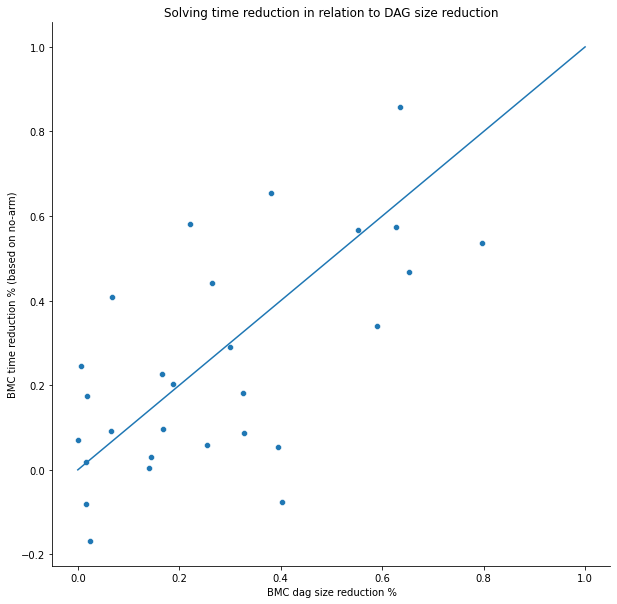

In [45]:
fig = plt.figure(figsize=(10,10))
plt.title('Solving time reduction in relation to DAG size reduction')
# Set x-axis label
plt.xlabel('BMC dag size reduction %')
# Set y-axis label
plt.ylabel('BMC time reduction % (based on no-arm)')
g = sns.scatterplot(x="bmc_dag_size_perc", y="bmc_solve_time_perc", data=cleaned)
sns.despine()
x = np.linspace(0, 1)
plot = g.plot(x, x)

In [46]:
np.corrcoef([cleaned["bmc_dag_size_perc"].to_numpy(), cleaned["bmc_solve_time_perc"].to_numpy()])

array([[1.        , 0.63996769],
       [0.63996769, 1.        ]])

# Compare against Arrays

In [97]:
# thL_thM["result_arr"] = thA_thM["result_arr"].fillna('Timeout')

In [115]:
thA_thM = pd.merge(data_arrays, data_base, on="job_name", how="right", suffixes=("_arr", "_hyb"))

In [128]:
thA_thM_agg = thA_thM[["bmc_dag_size_arr","bmc_dag_size_hyb", "bmc_pre_proc_time_arr", "bmc_pre_proc_time_hyb", "bmc_solve_time_arr", "bmc_solve_time_hyb"]].apply(["sum"]).astype(int)

In [130]:
thA_thM.loc[thA_thM["result_arr"] == 'Timeout', ['job_name']].count()

job_name    44
dtype: int64

In [131]:
thA_thM_agg

,bmc_dag_size_arr,bmc_dag_size_hyb,bmc_pre_proc_time_arr,bmc_pre_proc_time_hyb,bmc_solve_time_arr,bmc_solve_time_hyb
sum,69677,183369,30,8,9890,883


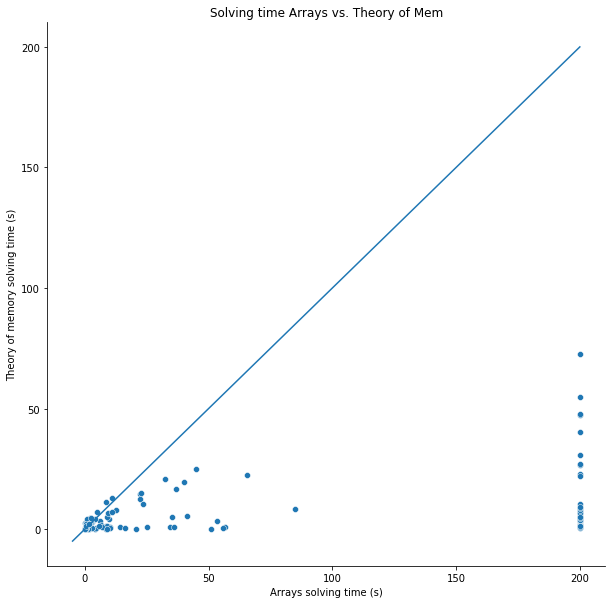

In [132]:
# solving time
fig = plt.figure(figsize=(10,10))
plt.title('Solving time Arrays vs. Theory of Mem')
# Set x-axis label
plt.xlabel('Arrays solving time (s)')
# Set y-axis label
plt.ylabel('Theory of memory solving time (s)')
g = sns.scatterplot(x="bmc_solve_time_arr", y="bmc_solve_time_hyb", data=thA_thM)
sns.despine()
x = np.linspace(-5, 200, 2)
plot = g.plot(x, x)

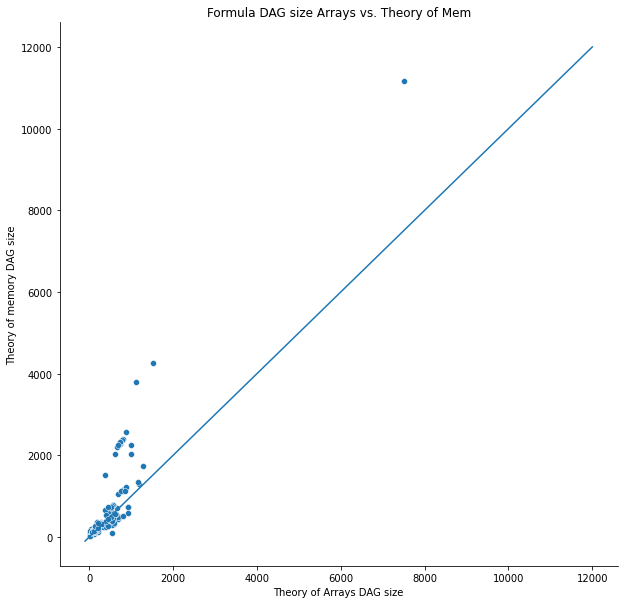

In [133]:
fig = plt.figure(figsize=(10,10))
plt.title('Formula DAG size Arrays vs. Theory of Mem')
# Set x-axis label
plt.xlabel('Theory of Arrays DAG size')
# Set y-axis label
plt.ylabel('Theory of memory DAG size')
g = sns.scatterplot(x="bmc_dag_size_arr", y="bmc_dag_size_hyb", data=thA_thM)
sns.despine()
x = np.linspace(-100, 12000, 2)
plot = g.plot(x, x)

Dag size is not apples to apples, for example `read(write(write(a, i1, v1), i2, v2), i) -> ite(i2 = i, v2, ite(i1 == i, v1, read(a, i))`, notice how additional `=` nodes are created.

# Compare against Lambdas

In [115]:
thL_thM = pd.merge(data_lambdas, data_base, on="job_name", how="right", suffixes=("_lb", "_hyb"))

In [122]:
thL_thM_agg = thL_thM[["bmc_dag_size_lb","bmc_dag_size_hyb", "bmc_pre_proc_time_lb", "bmc_pre_proc_time_hyb", "bmc_solve_time_lb", "bmc_solve_time_hyb"]].apply(["sum"]).astype(int)

In [123]:
thL_thM.loc[thL_thM["result_lb"] == 'Timeout', ['job_name']].count()

job_name    0
dtype: int64

In [124]:
thL_thM_agg

,bmc_dag_size_lb,bmc_dag_size_hyb,bmc_pre_proc_time_lb,bmc_pre_proc_time_hyb,bmc_solve_time_lb,bmc_solve_time_hyb
sum,138915,183369,53,8,570,883


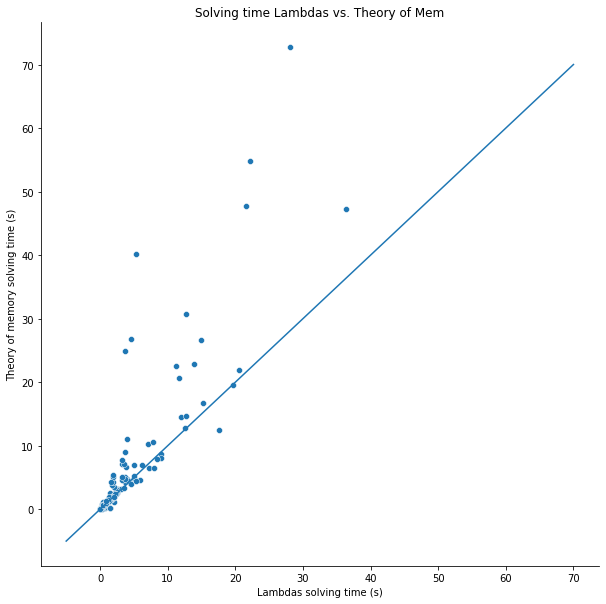

In [126]:
# solving time
fig = plt.figure(figsize=(10,10))
plt.title('Solving time Lambdas vs. Theory of Mem')
# Set x-axis label
plt.xlabel('Lambdas solving time (s)')
# Set y-axis label
plt.ylabel('Theory of memory solving time (s)')
g = sns.scatterplot(x="bmc_solve_time_lb", y="bmc_solve_time_hyb", data=thL_thM)
sns.despine()
x = np.linspace(-5, 70, 2)
plot = g.plot(x, x)

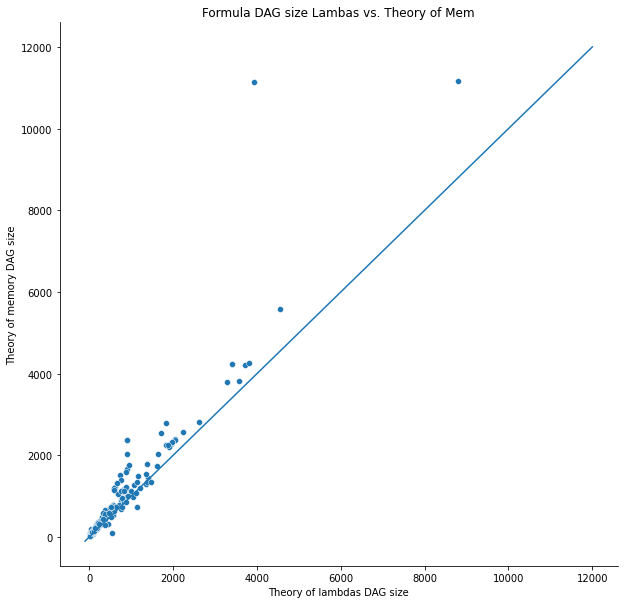

In [127]:
fig = plt.figure(figsize=(10,10))
plt.title('Formula DAG size Lambas vs. Theory of Mem')
# Set x-axis label
plt.xlabel('Theory of lambdas DAG size')
# Set y-axis label
plt.ylabel('Theory of memory DAG size')
g = sns.scatterplot(x="bmc_dag_size_lb", y="bmc_dag_size_hyb", data=thL_thM)
sns.despine()
x = np.linspace(-100, 12000, 2)
plot = g.plot(x, x)

# Now compare Lambdas with ARM

In [135]:
thL_thARM = pd.merge(data_lambdas, data_arm, on="job_name", how="right", suffixes=("_lb", "_hyb_arm"))

In [137]:
thL_thARM_agg = thL_thARM[["bmc_dag_size_lb","bmc_dag_size_hyb_arm", "bmc_pre_proc_time_lb", "bmc_pre_proc_time_hyb_arm", "bmc_solve_time_lb", "bmc_solve_time_hyb_arm"]].apply(["sum"]).astype(int)

In [138]:
thL_thARM.loc[thL_thARM["result_lb"] == 'Timeout', ['job_name']].count()

job_name    0
dtype: int64

In [139]:
thL_thARM_agg

,bmc_dag_size_lb,bmc_dag_size_hyb_arm,bmc_pre_proc_time_lb,bmc_pre_proc_time_hyb_arm,bmc_solve_time_lb,bmc_solve_time_hyb_arm
sum,138915,153892,53,7,570,697


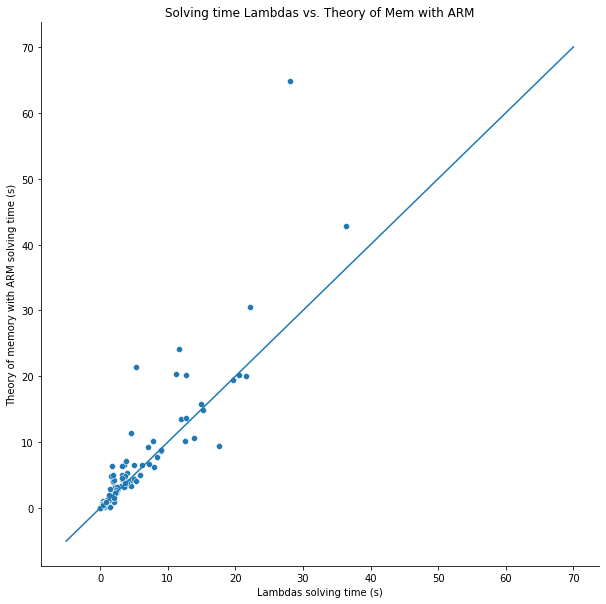

In [140]:
# solving time
fig = plt.figure(figsize=(10,10))
plt.title('Solving time Lambdas vs. Theory of Mem with ARM')
# Set x-axis label
plt.xlabel('Lambdas solving time (s)')
# Set y-axis label
plt.ylabel('Theory of memory with ARM solving time (s)')
g = sns.scatterplot(x="bmc_solve_time_lb", y="bmc_solve_time_hyb_arm", data=thL_thARM)
sns.despine()
x = np.linspace(-5, 70, 2)
plot = g.plot(x, x)

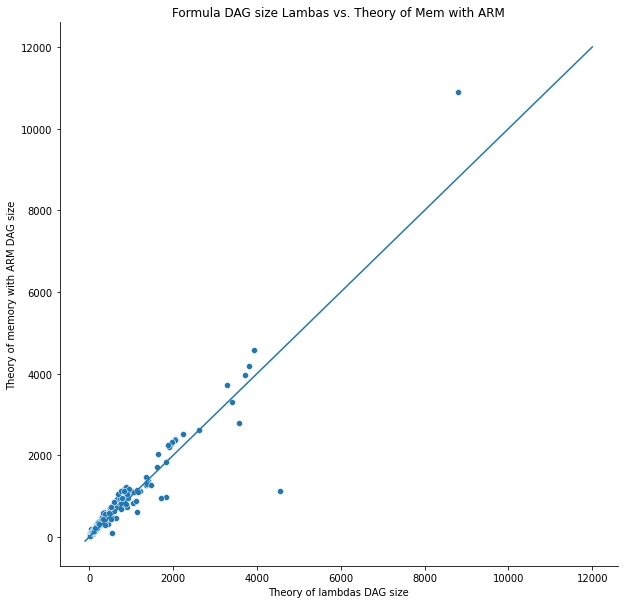

In [141]:
fig = plt.figure(figsize=(10,10))
plt.title('Formula DAG size Lambas vs. Theory of Mem with ARM')
# Set x-axis label
plt.xlabel('Theory of lambdas DAG size')
# Set y-axis label
plt.ylabel('Theory of memory with ARM DAG size')
g = sns.scatterplot(x="bmc_dag_size_lb", y="bmc_dag_size_hyb_arm", data=thL_thARM)
sns.despine()
x = np.linspace(-100, 12000, 2)
plot = g.plot(x, x)

In [155]:
base_sorted = data_base.sort_values("hybrid_row", ascending=False)
base_sorted.head(10)[['job_name', 'result', 'bmc_circuit_size', 'bmc_dag_size', 'bmc_time', 'bmc_solve_time', 'hybrid_row']]

,job_name,result,bmc_circuit_size,bmc_dag_size,bmc_time,bmc_solve_time,hybrid_row
219,linked_list_swap_contents,True,30,11129,31.16,30.69,6505.0
173,byte_buf_cat2,True,26,595,1.27,1.21,2971.0
44,array_list_pop_front_n,True,15,379,3.25,3.21,2616.0
216,array_list_set_at2,True,17,566,16.73,16.68,2361.0
57,byte_buf_write_from_whole_buffer,True,20,484,1.12,1.08,2263.0
213,hash_table_eq,True,14,11165,21.11,20.66,2262.0
155,array_list_set_at,True,19,553,19.63,19.60,2225.0
183,array_list_shrink_to_fit2,True,14,389,3.34,3.30,2095.0
223,byte_buf_write_from_whole_string2,True,14,2557,27.00,26.88,1939.0
220,byte_buf_write_from_whole_string,True,14,2784,40.26,40.14,1937.0
